<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E04_kaggle_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **kaggle housing leaderboard project**

> 평가 척도: RMSE
>
> 목표: 집값에 영향을 미치는 요인 분석

## **01. 데이터 살펴보기**

> train.csv: 모델 학습용 데이터
>
> test.csv: 모델 테스트용 데이터
>
> sample_submission.csv: 제출용 데이터 샘플

▶︎ 캐글 페이지(https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/data)에서 친절하게 데이터 정보를 제공해줍니다. 살펴봅시다.

>- **Data fields**
>
>ID : 집을 구분하는 번호
>
>date : 집을 구매한 날짜
>
>price : 집의 가격(Target variable)
>
>bedrooms : 침실의 수
>
>bathrooms : 화장실의 수
>
>sqft_living : 주거 공간의 평방 피트(면적)
>
>sqft_lot : 부지의 평방 피트(면적)
>
>floors : 집의 층 수
>
>waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
>
>view : 집이 얼마나 좋아 보이는지의 정도
>
>condition : 집의 전반적인 상태
>
>grade : King County grading 시스템 기준으로 매긴 집의 등급
>
>sqft_above : 지하실을 제외한 평방 피트(면적)
>
>sqft_basement : 지하실의 평방 피트(면적)
>
>yr_built : 지어진 년도
>
>yr_renovated : 집을 재건축한 년도
>
>zipcode : 우편번호
>
>lat : 위도
>
>long : 경도
>
>sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
>
>sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

## **02. 기준 데이터 생성하기**
> 이번 캐글에서는 전처리 샘플을 제공해줍니다.
>
> 개선을 위한 비교 기준이 있어야 하니, 제공받은 코드를 한 번 돌려서 점수를 확인해봅시다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# 파일 경로 수정

train_data_path = join('/content', 'train.csv')
sub_data_path = join('/content', 'test.csv')

print('Done!')

Done!


In [2]:
# 데이터 shape 확인

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


▶︎ target feature는 price입니다.

변수 y에 해당 컬럼을 저장하고, 학습 데이터에서는 제거해 주겠습니다.

In [3]:
y = data['price']
del data['price']

▶︎ 결측치를 확인하기 위해 데이터를 합쳐줍니다.

In [4]:
# 결측치 확인을 위한 학습 데이터와 테스트 데이터 합치기

train_len = len(data) # 추후 분리를 위한 인덱스 처리
data = pd.concat((data, sub), axis=0)

print(len(data))

print(data.head())

21503
   id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living1

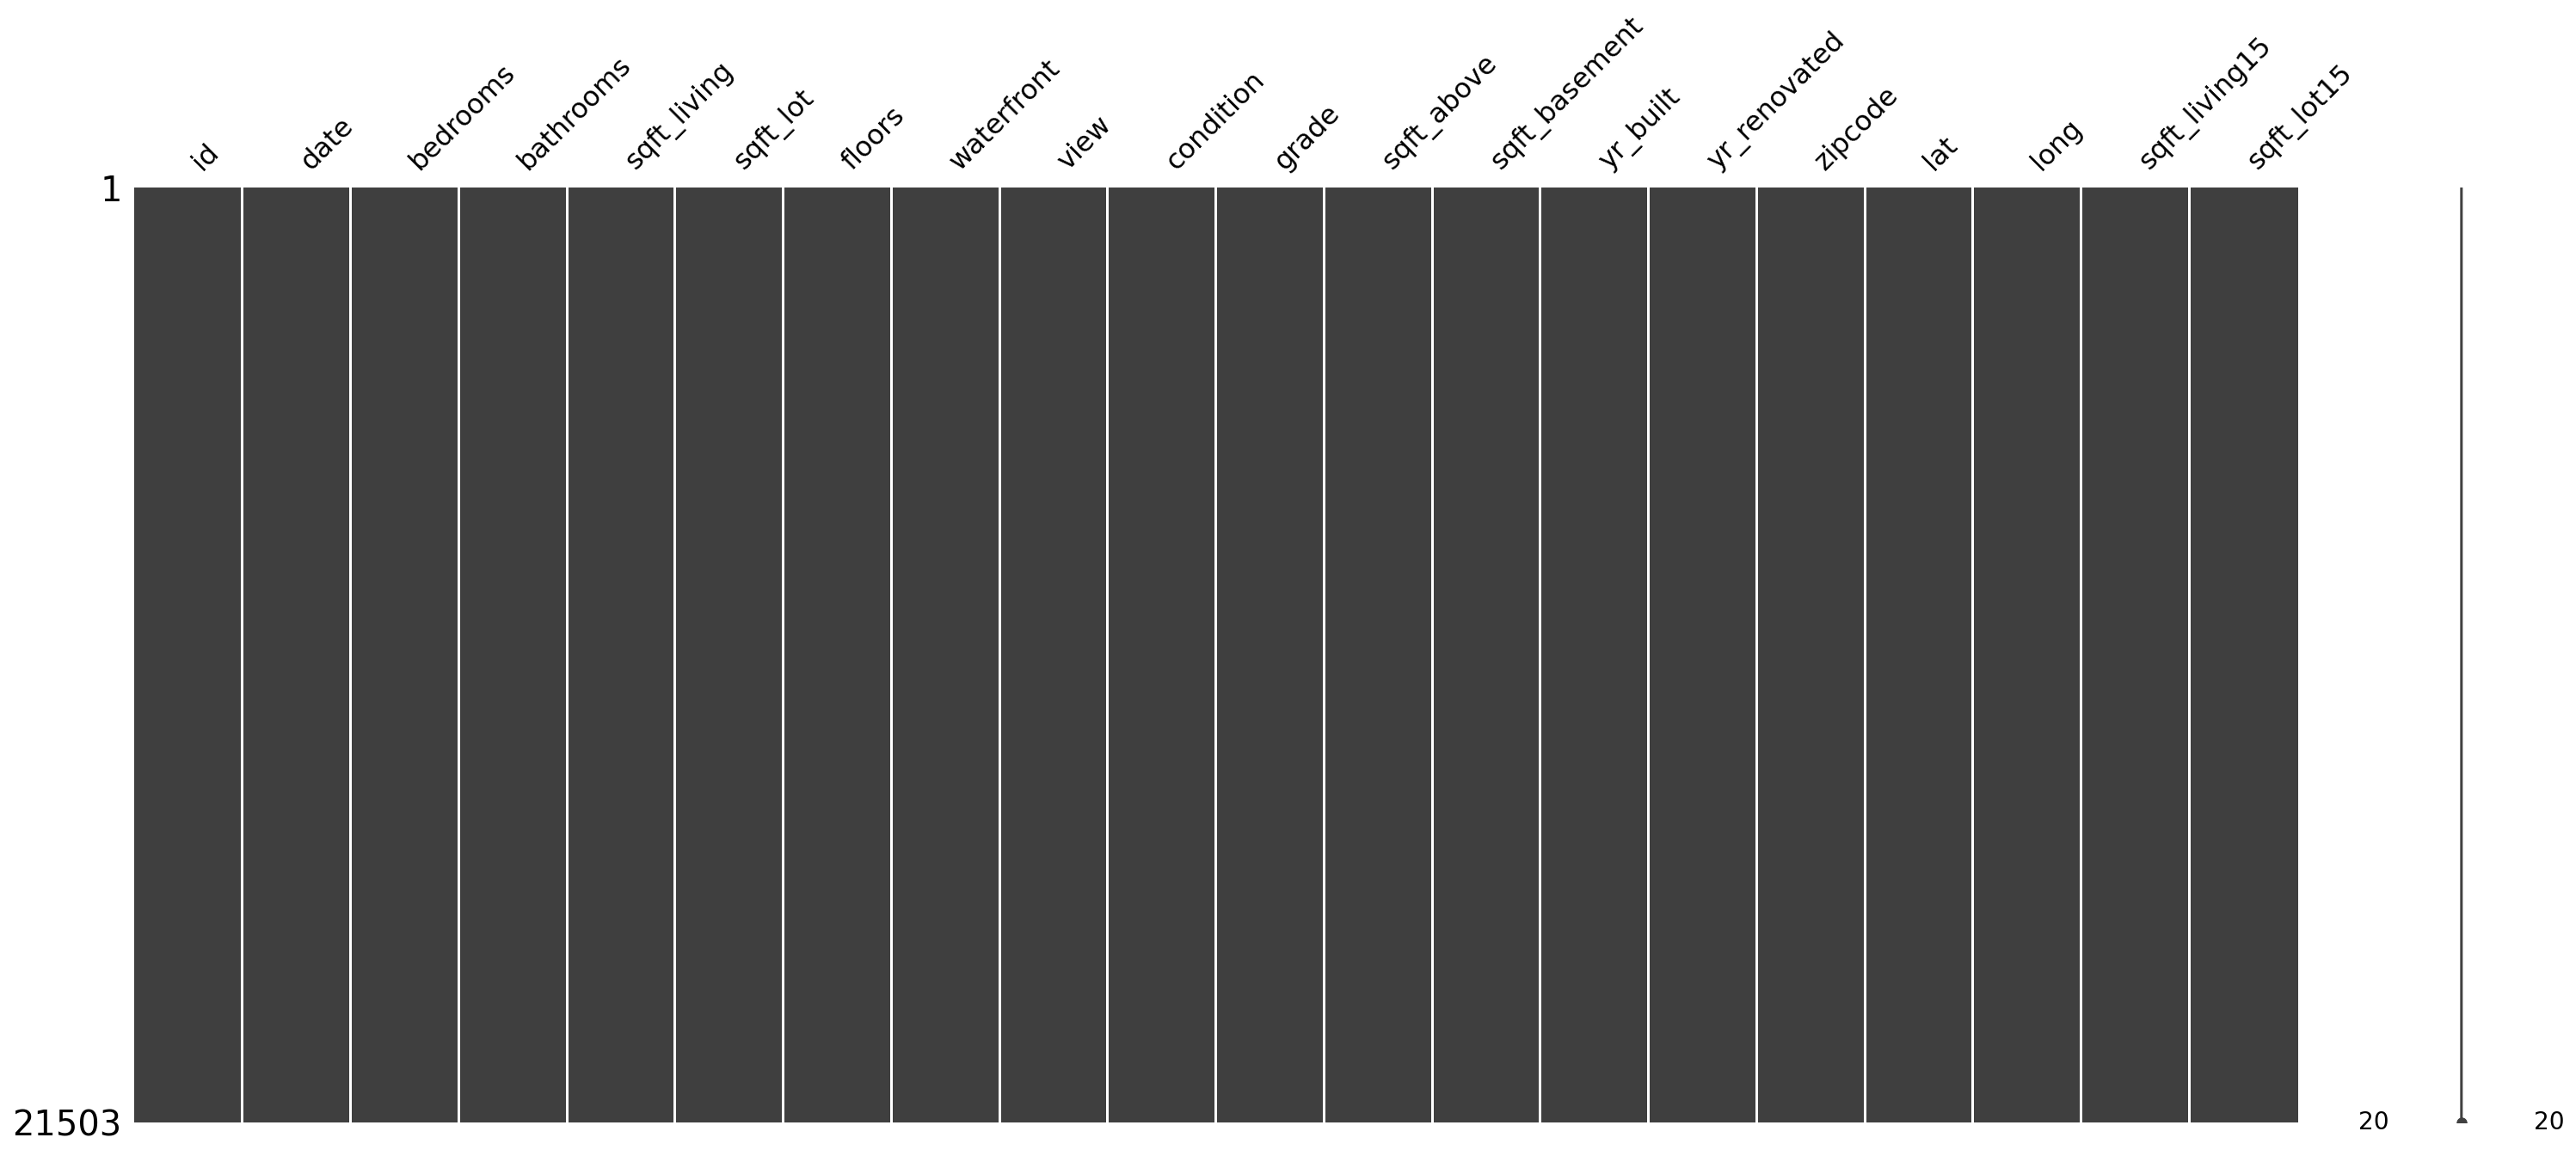

In [5]:
# 결측치 확인을 위한 시각화

msno.matrix(data)

▶︎ 결측치는 없는 것 같군요.

혹시 모르니 다른 방법으로 확인해 보겠습니다.

In [6]:
# 컬럼별로 결측치가 존재하는지 확인하고, 만약 있다면 몇 개나 있는지 출력

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


▶︎ 결측치가 없다는 것을 확인했습니다.

이제 집값 예측에 필요없는 id 컬럼을 제거해줍니다.

In [7]:
# id 컬럼 제거
# 제출 시 필요할 수도 있으니 sub_id에 저장

sub_id = data['id'][train_len:]
del data['id']

data.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


▶︎ date 변수는 연-월-일-시간 순서로 값을 가지고 있습니다.

중간에 T가 들어간 것을 보니 문자열 데이터겠죠?

day 값을 뺀 연/월만 고려하는 형태로 바꿔주겠습니다.

In [8]:
# date 변수 처리
# 앞 6자리까지가 연/월

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


▶︎ 잘 처리된 것 같네요. 

이제 데이터의 분포를 확인해봅시다.

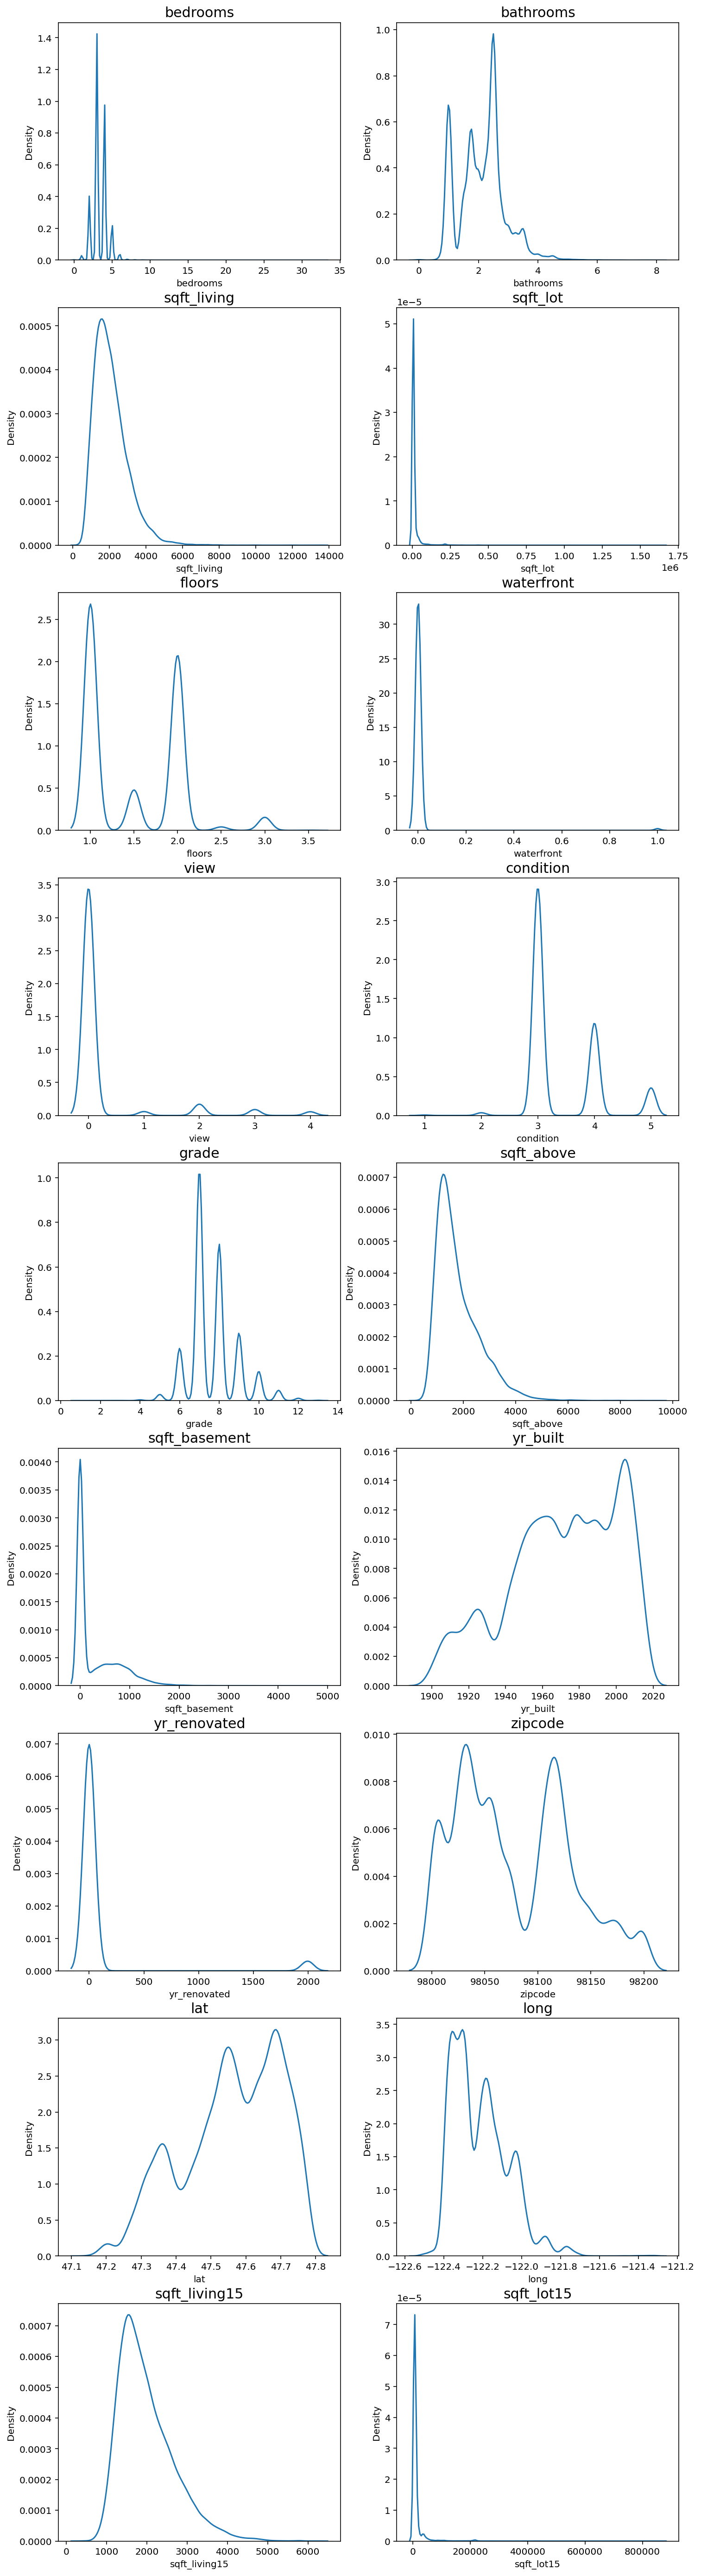

In [9]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

▶︎ 그래프를 보니 일부 데이터들이 편향돼 있습니다.

로그 변환을 통해 정규분포에 가깝게 변환해 주겠습니다.

In [10]:
# 데이터 변환

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('Done!')

Done!


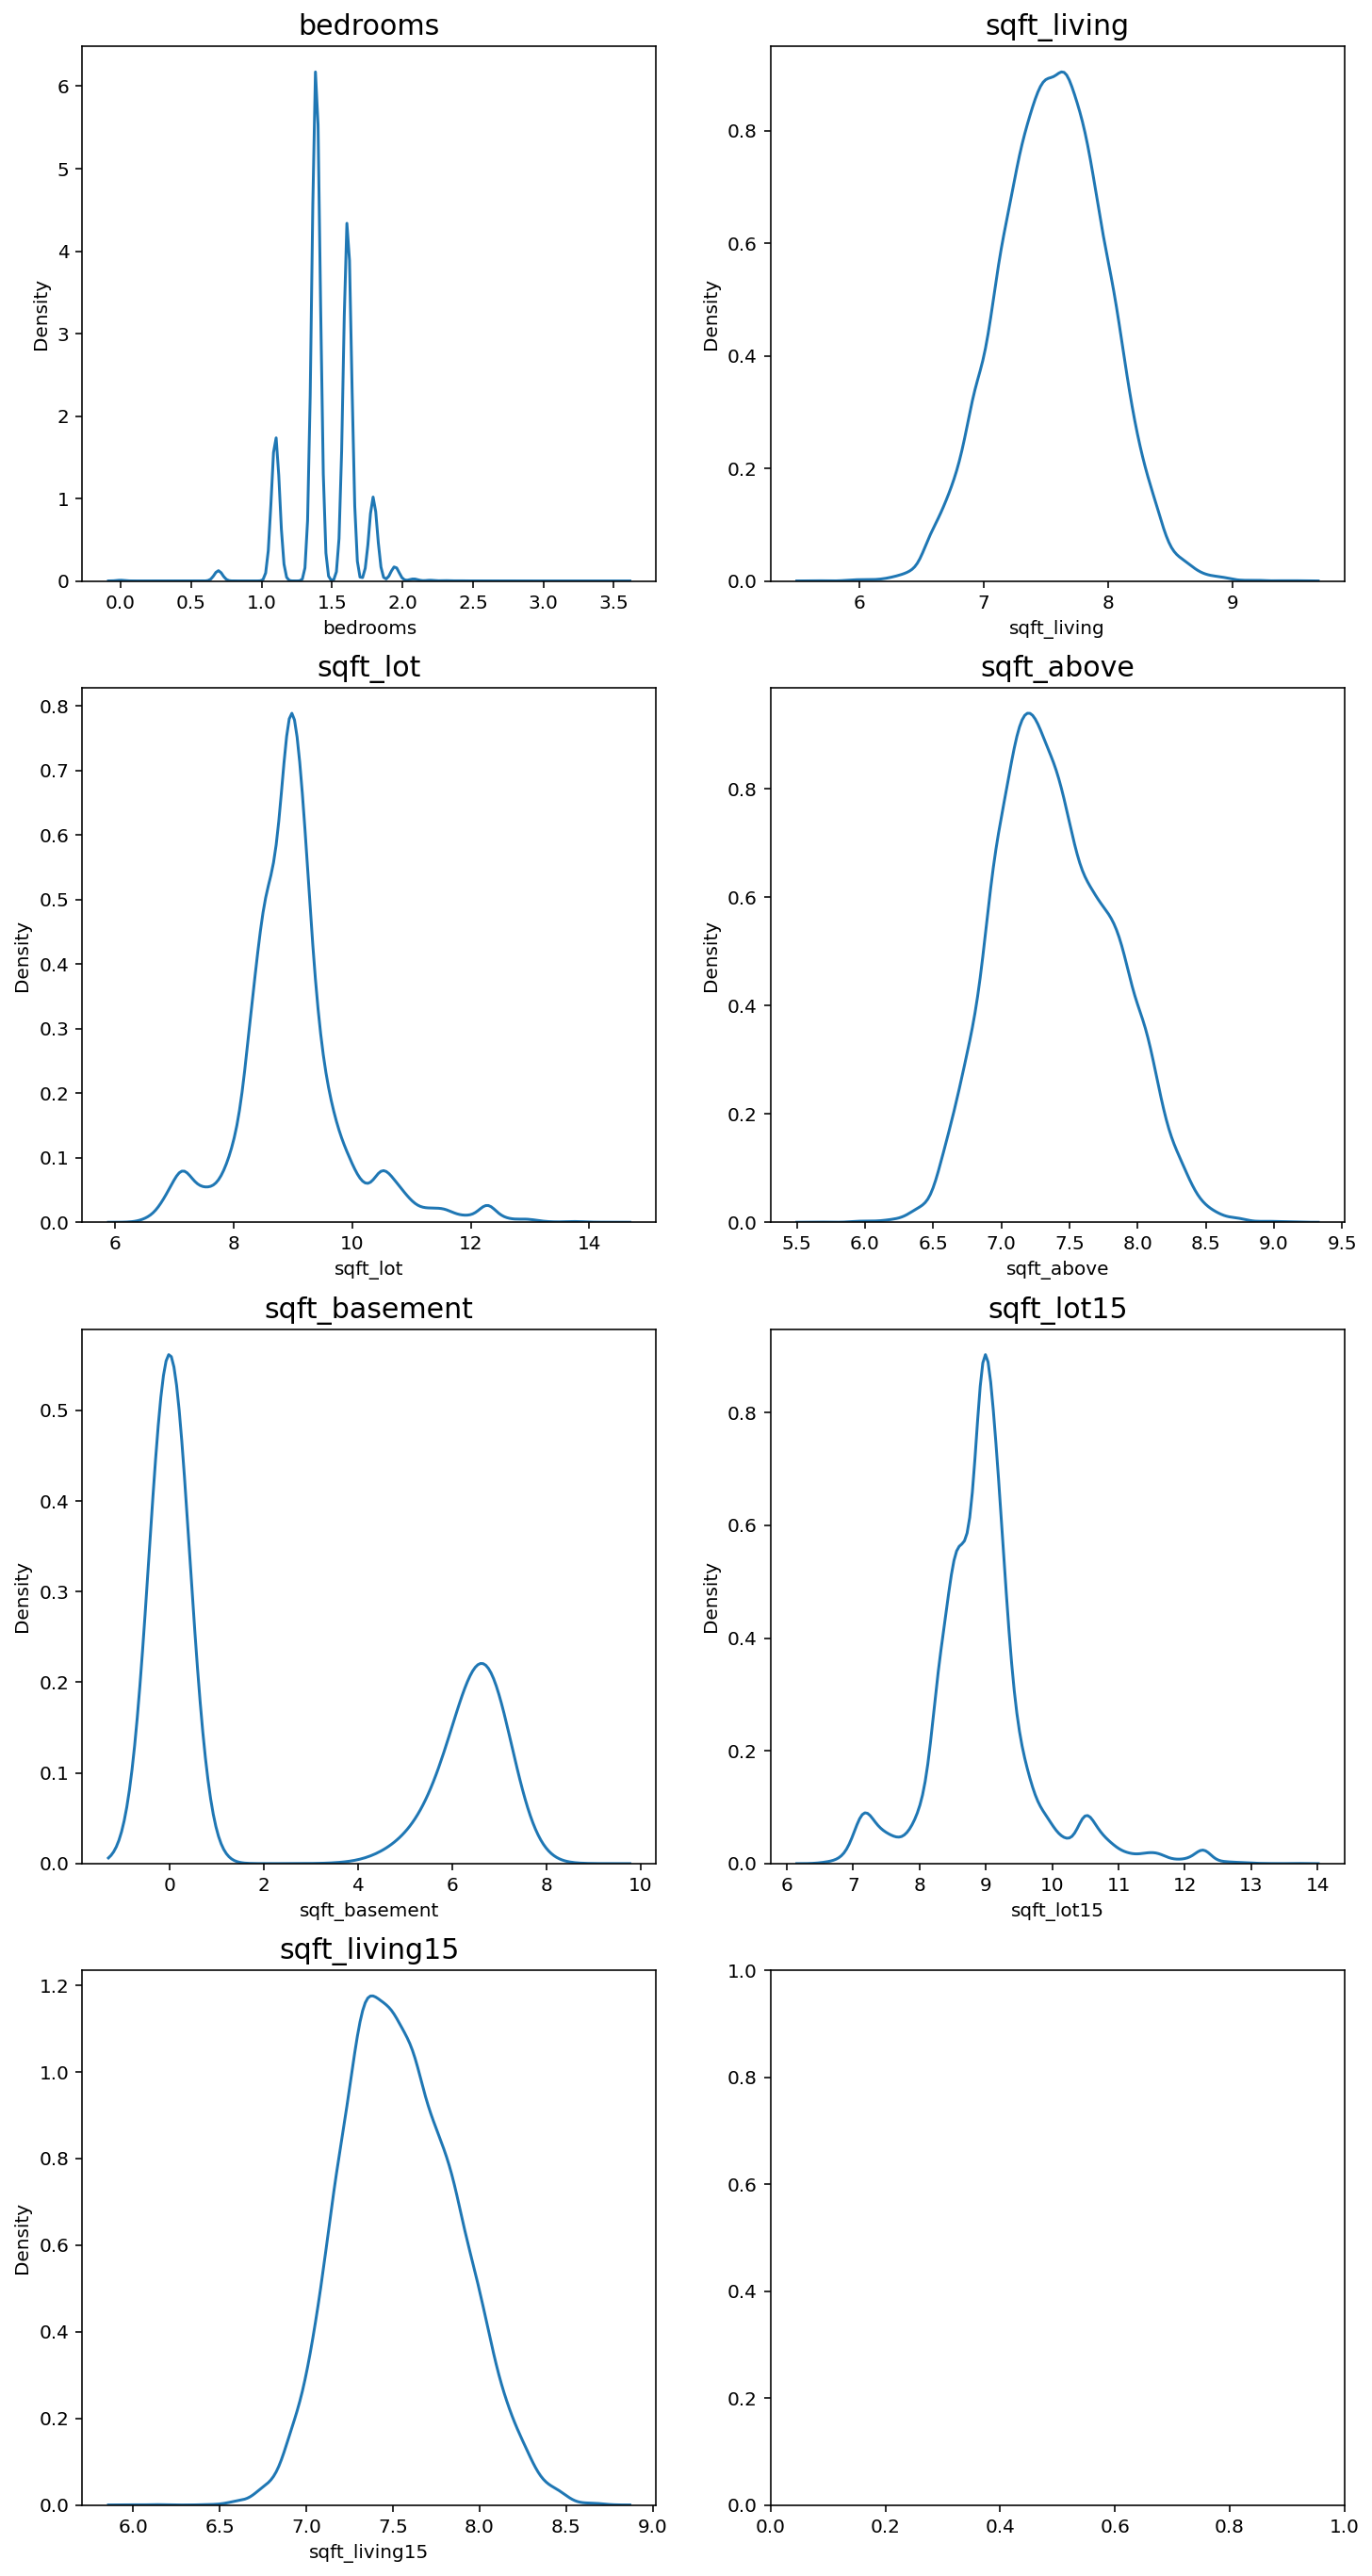

In [11]:
# 다시 시각화

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

▶︎ 훨씬 나아졌습니다. 이제 모델링을 진행합니다.

In [12]:
# 저장해둔 데이터 대입

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [20]:
# 블렌딩(=앙상블) 중 averaging 사용
# 사용 모델은 부스팅 계열 3가지

gboost = GradientBoostingRegressor(random_state=2019)
# xgboost = xgb.XGBRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=2019) # warning 메세지 출력에 따른 인자 추가
lightgbm = lgb.LGBMRegressor(random_state=2019)


# 모델 생성

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('Done!')

Done!


In [21]:
# 모델 검증에 사용할 함수 생성

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
print('Done!')

Done!


In [18]:
# 모델 테스트

get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[14:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


▶︎ 음, 정상 작동은 되지만 warning이 발생합니다.

linear 인자가 deprecated 됐으니 squarederror 인자를 사용하라는군요.

위로 올라가서 내용을 바꿔주고 다시 실행해 봅니다.

- troubleshooting: https://blog.naver.com/nailandhair/222580906913



In [22]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


▶︎ 잘 해결되었습니다.

결과값이 1에 가까울 수록 고성능이므로, 각 모델의 성능은 충분히 쓸 만한 것처럼 보입니다.

결과값을 얻었으니 이제 제출을 위한 파일을 만들어 줍니다.

In [23]:
# 앙상블을 사용하므로, 각 예측 결과를 평균내어 리턴하는 함수 생성

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('Done!')

Done!


In [24]:
# 예측값 생성

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

▶︎ 실수로 된 예측값들이 저장돼 있군요.

이제 이걸 어떻게 제출할 지 살펴봅니다.

In [25]:
data_dir = '/content/'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


▶︎ 샘플 제출파일을 보니 id와 price 두 컬럼을 가진 데이터셋으로 되어 있습니다.

여기에 맞춰 제출용 파일을 만들어 줍니다.

In [26]:
# 데이터셋 생성

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [27]:
# 파일에 저장

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/submission.csv


## **제출 결과**

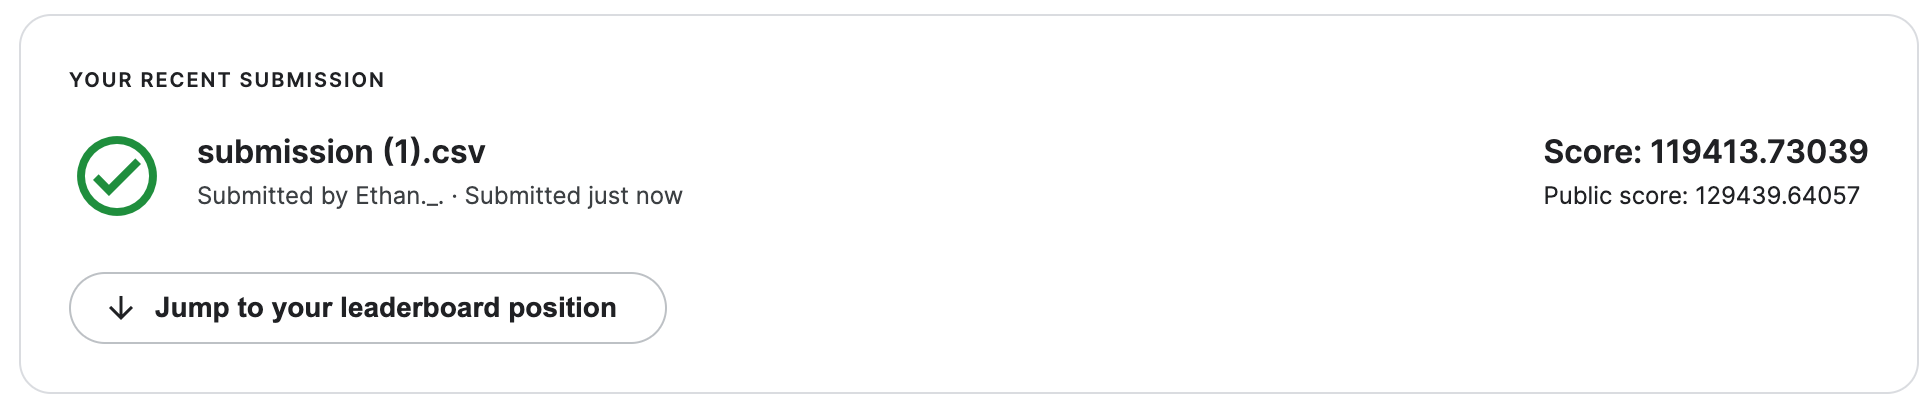

▶︎ 좋습니다! 기준점이 나왔네요.

이제부터 우리는 여러 방법을 써서 ***119413.7***점보다 높은 점수를 얻어보겠습니다.

----


## **00. Thinking...🤔**
> 모델의 성능을 개선시키는 것이 현재 목표입니다.
>
> 어떤 부분을 수정해야 할까요? 먼저 앞서 진행한 내용을 간략하게 나열해 보겠습니다.

    (1) 데이터 불러오기
    (2) 결측치 확인 및 기본적인 전처리
    (3) 편향된 데이터 변형
    (4) 모델 생성 (부스팅 모델 3개 -> averaging 사용)
    (5) 모델 학습
    (6) 예측값 생성
    (7) 제출 파일 생성


▶︎ 흠, 크게 2가지 방법을 생각할 수 있겠습니다.

피처 엔지니어링 방식이나 사용하는 모델을 바꿔 보거나,

현재 사용중인 모델의 하이퍼파라미터를 손보는 것입니다.

먼저 전자의 방법을 시도해 보겠습니다.

## **01. 피처 엔지니어링**

In [28]:
data_dir = '/content'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


▶︎ 앞에서는 id 컬럼을 지우고, date의 문자열 중 연/월까지만 받아왔었습니다.

이번에는 date 컬럼을 학습에 사용하기 위해 int형으로 변환해 보겠습니다.


In [29]:
# 일자는 따로 받지 않습니다. 집값이 매일 큰 폭으로 변동하지 않기 때문입니다.

train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


▶︎ 이어서 target, id 컬럼을 처리해줍니다.

In [30]:
y = train['price']
del train['price']

del train['id']

In [31]:
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


▶︎ 남은 컬럼을 확인해보니 잘 처리되었습니다.

test 데이터에서도 date 컬럼을 변환해주고 id 열을 지워줍니다.

price 열을 지워줄 필요는 없습니다.

In [32]:
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


▶︎ 더 해 줄만한 피처 전처리는 없는 것 같습니다.

타겟 벡터인 y를 확인해봅시다.


0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


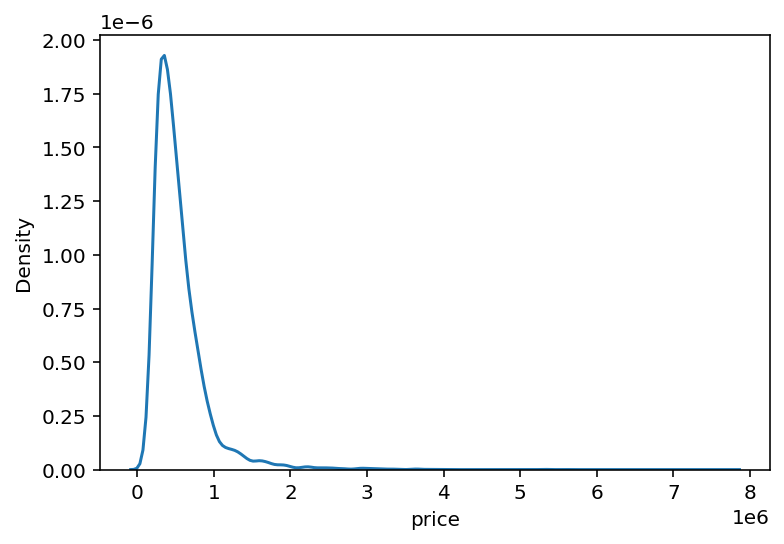

In [33]:
print(y)

sns.kdeplot(y)
plt.show()

▶︎ 데이터가 왼쪽으로 상당히 치우쳐 있습니다.

로그 변환을 통해 정규화해주고, 나중에 다시 되돌려서 비교해보겠습니다.
>- **np.expm1** | https://numpy.org/doc/stable/reference/generated/numpy.expm1.html
>- **np.log1p** | https://numpy.org/doc/stable/reference/generated/numpy.log1p.html

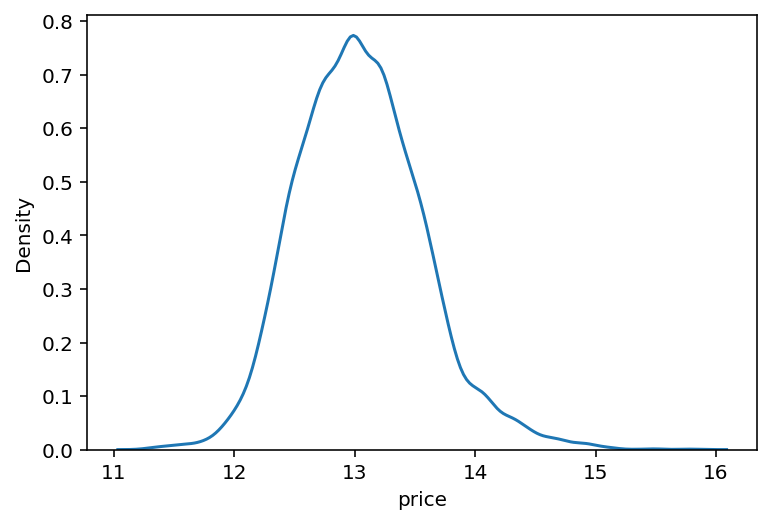

In [34]:
# 로그 변환

y = np.log1p(y)
sns.kdeplot(y)
plt.show()

▶︎ 잘 변환되었습니다.

In [35]:
# 피처 처리 결과 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

▶︎ 전부 정수 또는 실수형 데이터로 잘 처리되었습니다.


## **02. 하이퍼파라미터 튜닝**

이제 모델을 생성하고, 학습시켜서 예측까지 진행해 보겠습니다.

하이퍼파라미터를 튜닝할 예정이므로, 매번 번거롭게 하나하나 처리하는 대신 편의상 함수를 만들어줍니다.

In [36]:
# RandomForest, xgboost, lightgbm, GradientBoosting 사용

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse


# 평가용 rmse 함수 생성
# 로그를 취해주었으니 다시 변환
def rmse(y_test, y_pred):
    return np.sqrt(mse(np.expm1(y_test), np.expm1(y_pred)))


# 자동화를 위한 변수 정의

random_state = 2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


# 모델링 함수 생성
def modeling(models, train, y):

    df = {}
    for model in models:

        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 데이터셋 분리
        X_train, X_test, y_train, y_test = tts(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # df에 내림차순으로 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    print(df)


print('Done!')

Done!


▶︎ 정상적으로 작동하는지 한 번 테스트해봅니다.

In [37]:
modeling(models, train, y)

[14:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'GradientBoostingRegressor': 130361.23368538941, 'XGBRegressor': 132088.01930383555, 'LGBMRegressor': 120099.06723661404, 'RandomForestRegressor': 135139.59142571784}


▶︎ 잘 작동하는 것 같네요.

피처 엔지니어링을 포함한 전처리 과정과 모델 준비까지 끝났으니, 이제 하이퍼파라미터를 만져봅시다.

▶︎ 먼저 그리드 탐색을 시도해보겠습니다.

그리드 탐색은 사람이 하이퍼파라미터 값들을 정해주면,

해당 값들로 만들어질 수 있는 모든 조합을 탐색하는 방법입니다.

>- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
>
>- scoring : 모델의 성능을 평가할 지표
>
>- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
>
>- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
>
>- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


In [38]:
# 그리드 탐색 사용
from sklearn.model_selection import GridSearchCV

print('Done!')

Done!


In [39]:
# xgboost
param_grid = {
    'n_estimators': [50, 100],  # n_estimators 값 2개 지정 (50, 100) / estimator 객체 개수가 50개일때, 100개일때
    'max_depth': [1, 10],       # max_depth 값 2개 지정 (1, 10) / 최대 차수가 1일때와 10개일때
}

In [40]:
# LightGBM
model = LGBMRegressor(random_state=random_state)    # 모델로는 LGBM 회귀 사용

In [47]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)              # 매회 교차검증 5회씩 반복

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

▶︎ 하이퍼파라미터를 n_estimators 2개, max_depth 2개씩 넣어주었으니 2X2=4가지의 가짓수를 갖게 됩니다.

교차 검증(cross validation)이 회당 5번씩 이뤄지므로 4X5 = 20회의 fitting이 진행되었습니다.

학습한 모델은 5번씩 교차검증 후 평균낸 값을 가지고 있겠지요?

In [48]:
# 결과 확인
grid_model.cv_results_

{'mean_fit_time': array([0.31822019, 0.43128843, 1.08848767, 1.51712346]),
 'mean_score_time': array([0.03450365, 0.03657746, 0.06300497, 0.05020862]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

▶︎ 우리가 원하는 수치는 각 하이퍼파라미터 조합에 따른 최적의 결과값입니다.

따라서 각 하이퍼파라미터의 조합인 params과 결과값인 mean_test_score 값을 가져오면 되겠군요.

In [49]:
# 파라미터 조합 가져오기
params = grid_model.cv_results_['params']
print(params)

# 점수 결과값 가져오기
score = grid_model.cv_results_['mean_test_score']
print(score)

[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.07339447 -0.05502043 -0.02917734 -0.02702714]


In [50]:
# 이제 합쳐주면 됩니다.
result = pd.DataFrame(params)
result['score'] = score

result

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


▶︎ 결과값을 보기 좋게 편집해 주겠습니다.

In [51]:
# 음수이니 -1을 곱해주고,
# 루트 연산까지 진행해 줍니다.

result['RMSE'] = np.sqrt(-1 * result['score'])
result

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


▶︎ 앞서 살펴본 6자리 숫자의 RMSE 값에 비하면 터무니없이 작습니다.

y에 들어 있는 target data에 로그를 취했기 때문입니다.

즉, 엄밀히 말해서 위 표의 RMSE는 RMSLE(Root Mean Squared Log Error)가 됩니다.

따라서 표의 내용을 수정해 줍니다.

In [52]:
# 컬럼명 변경
result = result.rename(columns={'RMSE': 'RMSLE'})

# 결과값 정렬
result = result.sort_values('RMSLE')

result

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


▶︎ max_depth = 10, n_estimators = 100일때 가장 성능이 좋은 것을 확인할 수 있습니다!

---

## **03. 제출용 파일 생성**

In [54]:
# 편의를 위한 함수 생성

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):

    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    result = pd.DataFrame(params)
    result['score'] = score
    
    # RMSLE 값 계산 후 정렬
    result['RMSLE'] = np.sqrt(-1 * result['score'])
    result = result.sort_values('RMSLE')

    return result

print('Done!')

Done!


▶︎ 앞에서 (max_depth, n_estimators) = (10, 100) 일 때 가장 고성능이라는 걸 확인했습니다.

이제 결과값을 담은 파일을 생성해서 제출해봅시다.

In [56]:
# 모델 생성 및 학습
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)

# 예측값 생성
prediction = np.expm1(model.predict(test))

prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [57]:
# 파일 구조 확인
data_dir = '/content'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [59]:
# 데이터 저장
submission['price'] = prediction

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/submission_lgbm_RMSLE_0.164399.csv


▶︎ 편의상 함수로 묶어 놓겠습니다.

In [60]:
# 파일로 저장해주는 함수

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

## **04. 결과 확인**

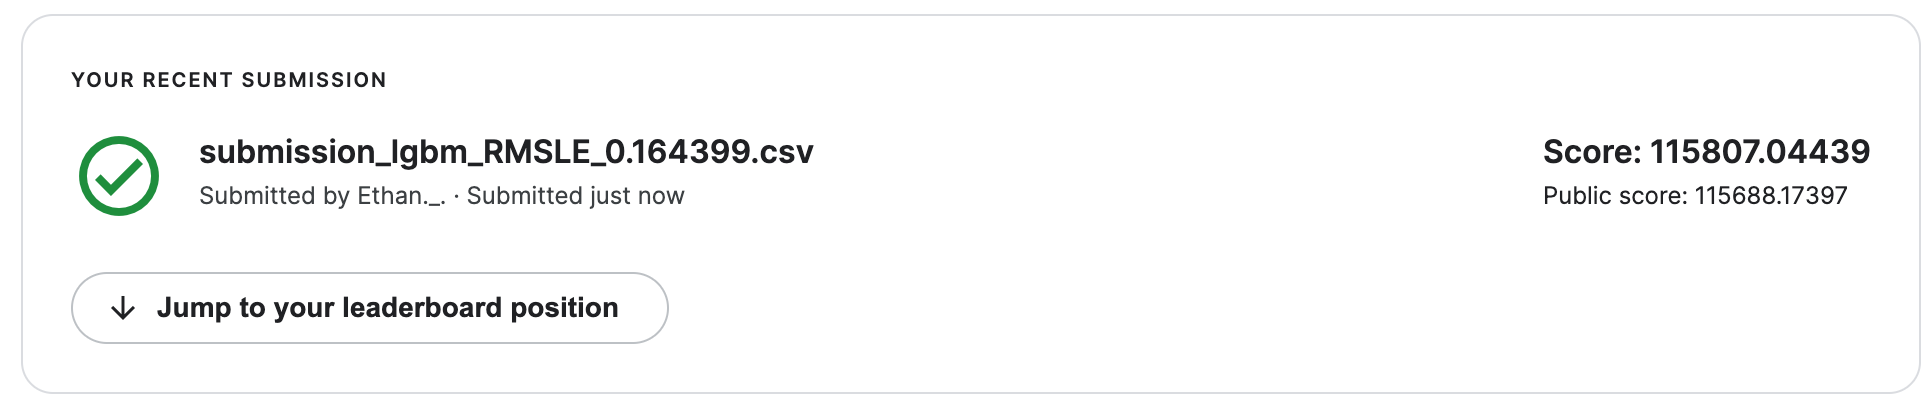

▶︎ 아까 제출 기준이 **119413.7**점이었는데, 이번엔 **115807**점을 받았습니다.

약 **3%의 성능이 향상**되었다고 볼 수도 있겠네요!

---

## **Try Again...**

11만 점 아래의 점수를 받을 수 있도록 다시 한 번 해 봅시다.

In [129]:
train2 = pd.read_csv('/content/train.csv')
test2 = pd.read_csv('/content/test.csv')

train2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [130]:
# 피처 엔지니어링 작업을 진행합니다.

y2 = np.log1p(train2['price'])

del train2['price']
del train2['id']
del test2['id']

train2['date'] = train2['date'].apply(lambda i:i [:6]).astype(int)
test2['date'] = test2['date'].apply(lambda i:i [:6]).astype(int)

train2.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


▶︎ 변수 설명을 보니 우편번호도 집값에 큰 영향을 미칠 것 같진 않습니다.

하지만 일단은 포함시켜서 진행하겠습니다.

- **xgboost 하이퍼파라미터** | https://blog.naver.com/dlekdms7931/222719354333

In [131]:
from lightgbm.basic import LightGBMError

# 하이퍼 파라미터 변경

# xgboost
param_grid = {
    'n_estimators': [100, 200, 300],     # tree 개수 (weak learner) | 디폴트 100
    'max_depth': [10, 15, 20],                      # 트리 깊이 | 디폴트 6
    'eta': [0.01, 0.005]                            # learning rate
}

# model
model_2 = LGBMRegressor(random_state=random_state)

In [132]:
# 그리드 서치 실행

my_GridSearch(model_2, train2, y2, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,eta,max_depth,n_estimators,score,RMSLE
8,0.010,20,300,-0.026091,0.161527
17,0.005,20,300,-0.026091,0.161527
2,0.010,10,300,-0.026127,0.161640
11,0.005,10,300,-0.026127,0.161640
10,0.005,10,200,-0.026188,0.161828
1,0.010,10,200,-0.026188,0.161828
7,0.010,20,200,-0.026245,0.162003
16,0.005,20,200,-0.026245,0.162003
5,0.010,15,300,-0.026269,0.162079
14,0.005,15,300,-0.026269,0.162079


▶︎ learning_rate=0.01 아래는 별 의미가 없어 보입니다.

결과값을 보아하니 과적합이 의심되지만.... 일단 계속 진행해보겠습니다.

In [133]:
# 모델 생성 및 학습
# 기본 반복값이 100이므로 늘려줍니다.

model_2 = LGBMRegressor(n_iterations=1000, learning_rate=0.01, max_depth=20, n_estimators=300, random_state=random_state)
model_2.fit(train2, y2)

# 예측값 생성
prediction2 = np.expm1(model_2.predict(test2))

prediction2

array([ 486945.64167946,  427655.77878905, 1251829.48870886, ...,
        449665.92293607,  351121.012207  ,  432214.26252844])

In [134]:
# 제출용 파일 생성
submission = pd.read_csv('/content/sample_submission.csv')
submission['price'] = prediction2

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '3')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


/content/submission_lgbm_RMSLE_3.csv


## **Result...**

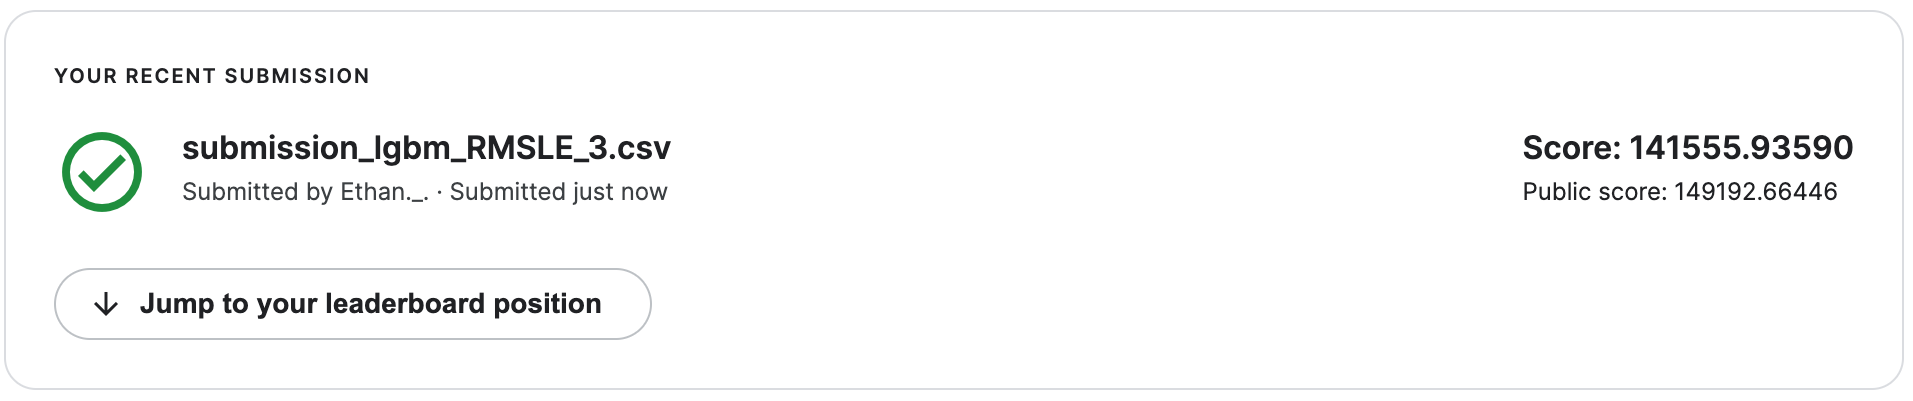

▶︎ 흠, 역시 오버피팅이 된 것 같습니다. 😨

그렇다면 이번에는 하이퍼파라미터는 그대로 두고, 우편번호 컬럼을 지워보겠습니다.

In [135]:
# 파일 불러오기
train3 = pd.read_csv('/content/train.csv')
test3 = pd.read_csv('/content/test.csv')

# 피처 엔지니어링
y3 = np.log1p(train3['price'])

del train3['price']
del train3['id']
del test3['id']
del train3['zipcode']
del test3['zipcode']

train3['date'] = train3['date'].apply(lambda i:i [:6]).astype(int)
test3['date'] = test3['date'].apply(lambda i:i [:6]).astype(int)

train3.head()



,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


▶︎ 다시 모델학습을 시켜봅니다.

In [136]:
# 하이퍼 파라미터 변경

# xgboost
param_grid = {
    'n_estimators': [100, 200, 300],           # tree 개수 (weak learner) | 디폴트 100
    'max_depth': [5, 10, 20],                 # 트리 깊이 | 디폴트 6
    'eta': [0.01, 0.02]                       # learning rate
}

# model
model_3 = LGBMRegressor(random_state=random_state)


# 그리드 서치 실행
my_GridSearch(model_3, train3, y3, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,eta,max_depth,n_estimators,score,RMSLE
8,0.01,20,300,-0.026446,0.162624
17,0.02,20,300,-0.026446,0.162624
7,0.01,20,200,-0.026527,0.162872
16,0.02,20,200,-0.026527,0.162872
5,0.01,10,300,-0.026594,0.163076
14,0.02,10,300,-0.026594,0.163076
4,0.01,10,200,-0.026619,0.163153
13,0.02,10,200,-0.026619,0.163153
2,0.01,5,300,-0.026966,0.164214
11,0.02,5,300,-0.026966,0.164214


▶︎ 결과를 보니 여전히 과적합이 의심되긴 합니다.....만,

일단은 추출된 best 조합으로 예측값을 내서 제출해 보겠습니다.

만약 점수가 큰 변동이 없다면 tree 개수를 줄이면 되겠지요?

In [137]:
# 모델 생성 및 학습
model_3 = LGBMRegressor(n_iterations=1000, learning_rate=0.01, max_depth=20, n_estimators=300, random_state=random_state)
model_3.fit(train3, y3)

# 예측값 생성
prediction3 = np.expm1(model_3.predict(test3))

prediction3

array([ 489555.13110474,  432281.12820419, 1247275.76710094, ...,
        439132.88386343,  354424.69564136,  427851.30176004])

In [138]:
# 제출용 파일 생성
submission = pd.read_csv('/content/sample_submission.csv')
submission['price'] = prediction3

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '3')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


/content/submission_lgbm_RMSLE_3.csv


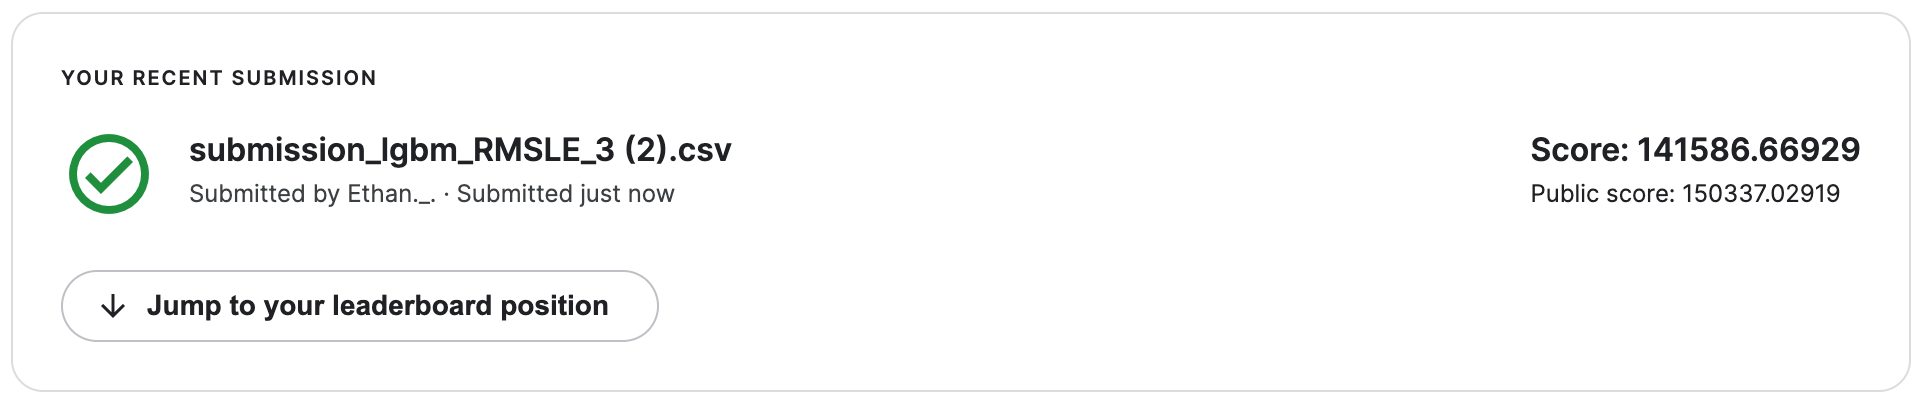

▶︎ 데이터는 여전히 오버피팅된 것 같네요.

점수 결과값을 보니 아무래도 zipcode 변수가 집값과 관계가 없을 것이라는 가설이 틀린 것 같군요.

아마 우리나라에서 학군에 따라 집값이 바뀌듯, 살기 좋은 지역의 집들은 비슷한 우편번호 규칙을 갖고 있어서 이에 영향을 받는 것 같습니다.

다만, 큰 영향력은 없어보입니다.

아무래도 ***각 변수들이 목표 변수에 얼마나 영향력을 미치는지*** 알아봐야겠군요.

---

## **Thinking again...🤔🤔🤔**

> 각 변수들이 목표 변수에 얼마나 영향력을 미치는지 알아보려면 어떻게 해야 할까요?
>
> 일단 처음부터 다시 차근차근 살펴봅시다.

In [294]:
# 파일 불러오기
train4 = pd.read_csv('/content/train.csv')
test4 = pd.read_csv('/content/test.csv')

# 일자까지 포함해 줍니다.
train4['date'] = train4['date'].apply(lambda i:i [:8]).astype(int)
test4['date'] = test4['date'].apply(lambda i:i [:8]).astype(int)

train4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


> **참고 커널:** https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12

▶︎ 우리는 price 변수와 다른 변수들의 상관계수가 궁금합니다.

head를 보니 범주형 데이터(yr_renovated, view, waterfront 등)도 포함돼 있군요.

따라서 스피어만 상관관계를 구하면 어떤 변수가 얼마나 영향력을 가지고 있는지 알 수 있겠죠?

> **스피어만 상관관계:** https://blog.naver.com/dbfladbfla12/221854959315
>
> **공식 도큐먼트:** https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html?highlight=corr

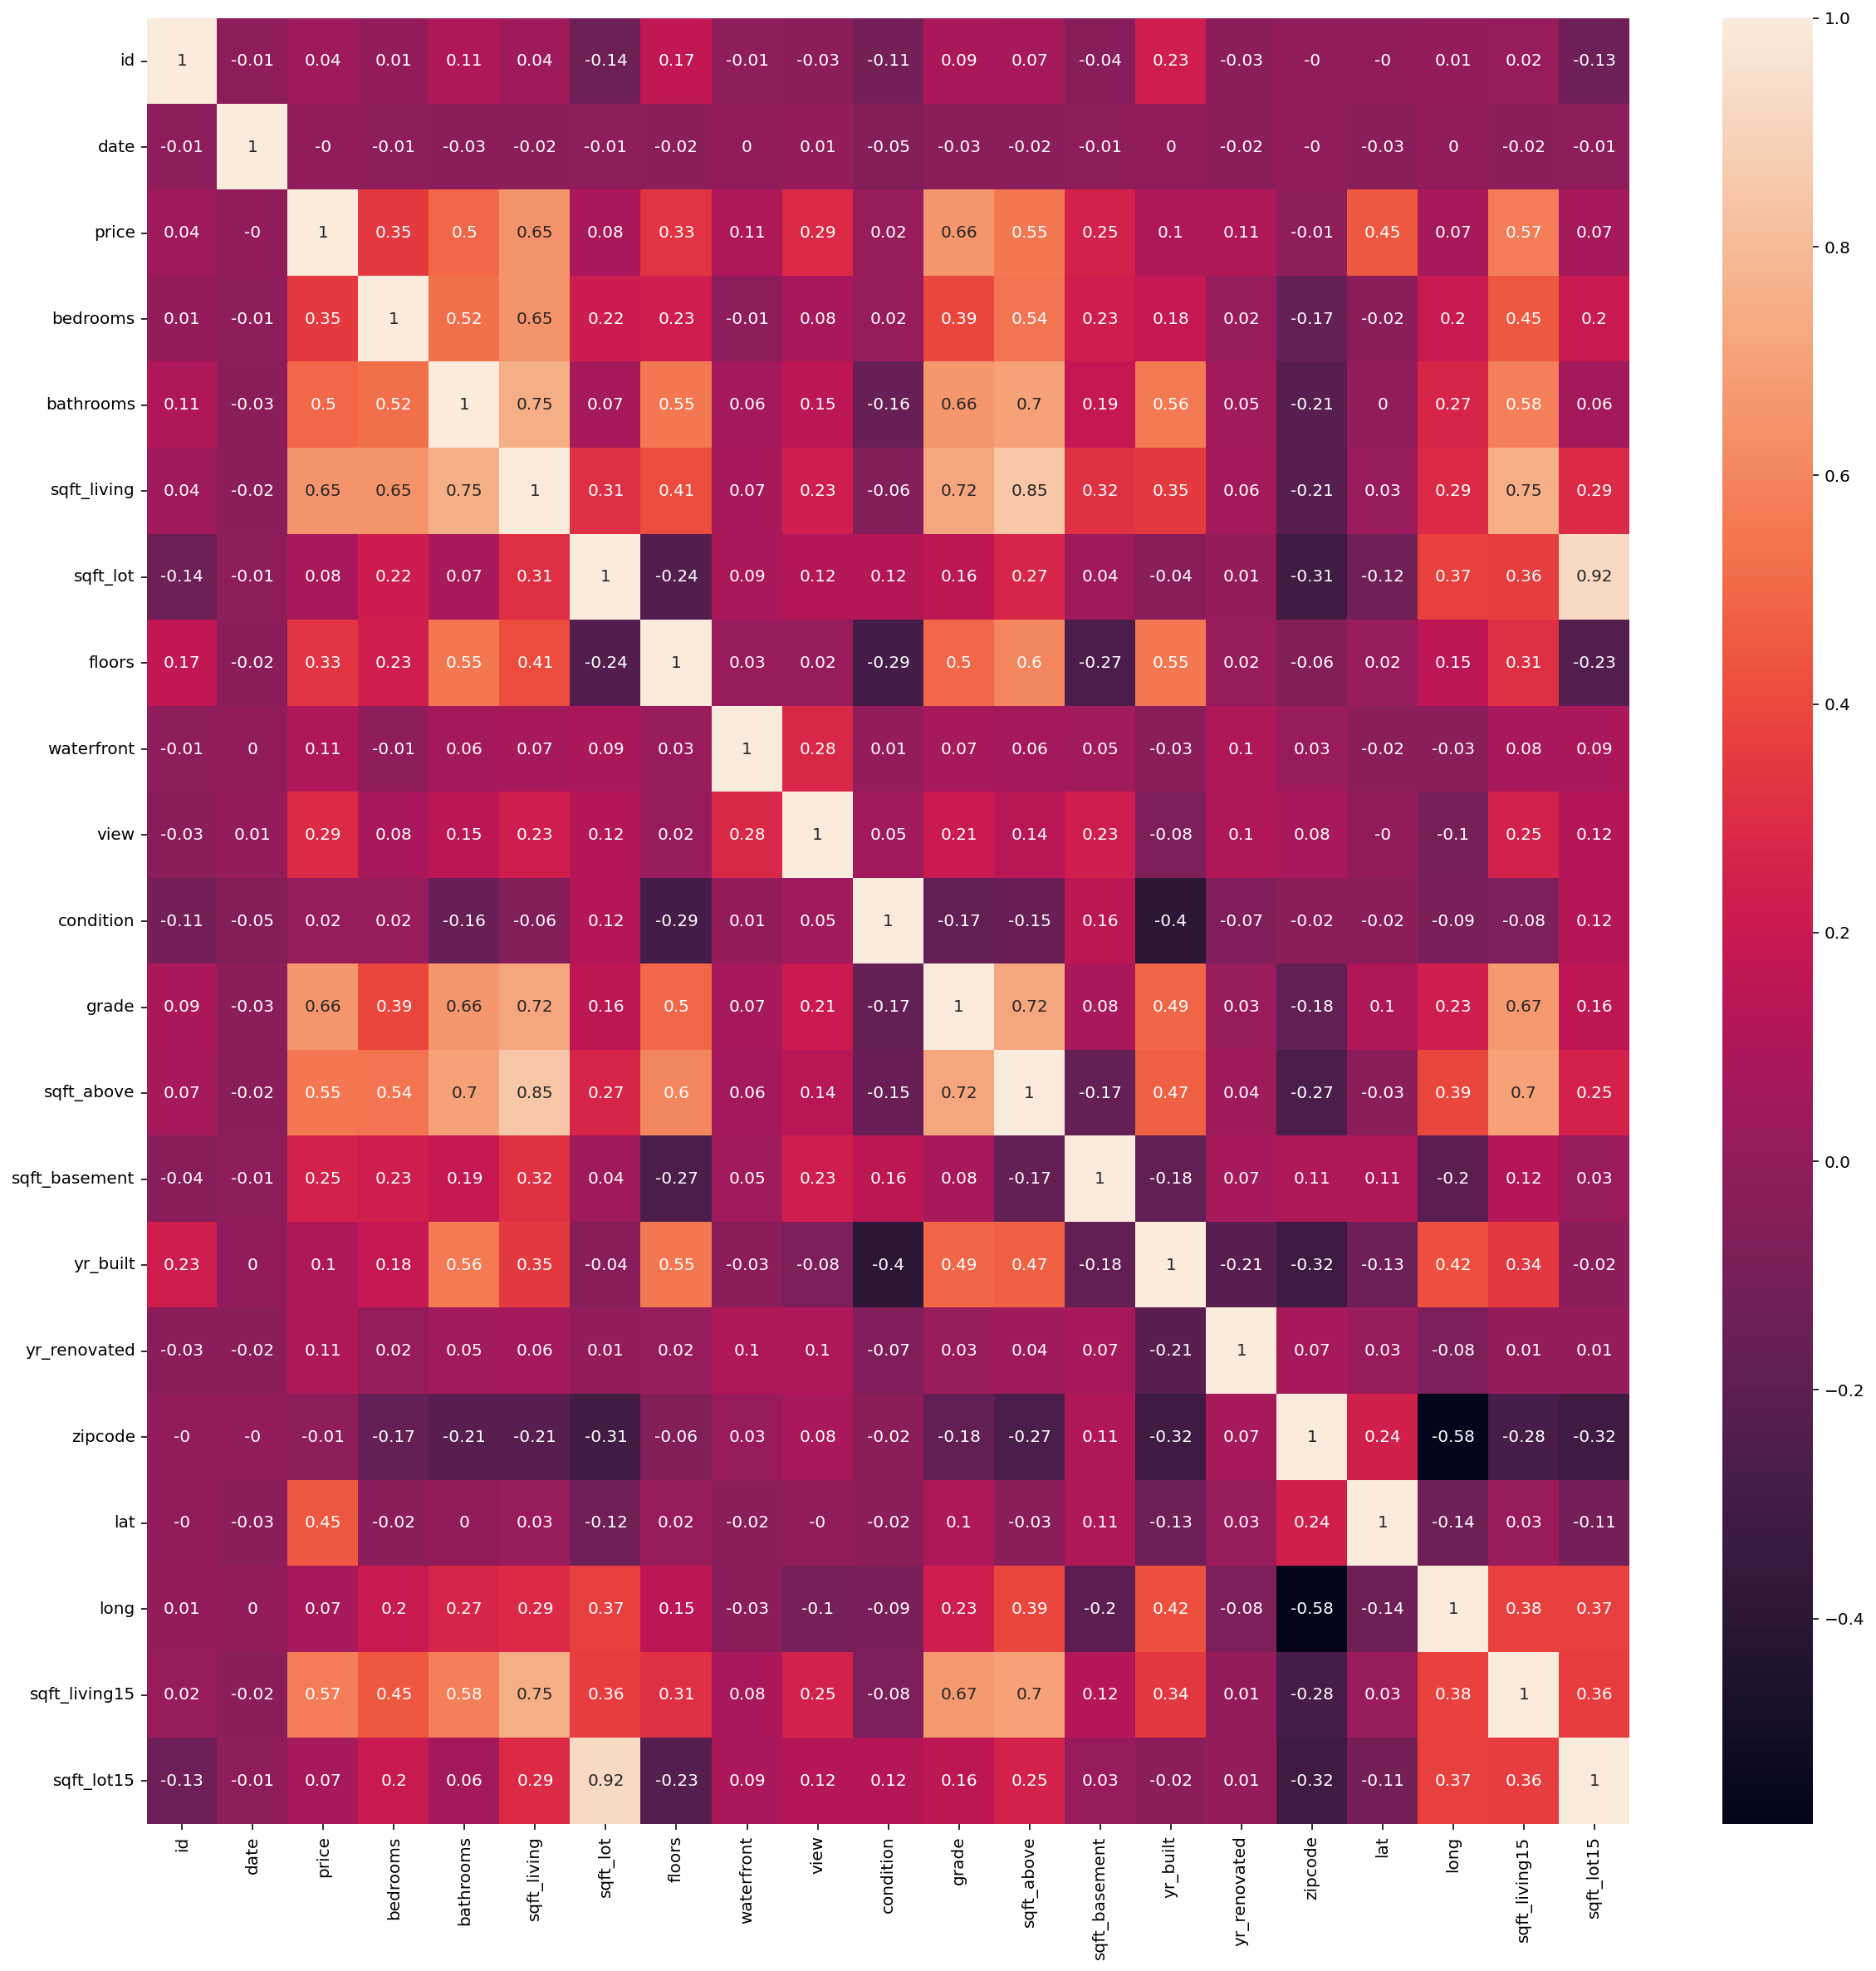

In [295]:
import seaborn as sns

# 스피어만 상관관계 구하기
sprm = train4.corr(method='spearman').round(2)

# 시각화
plt.figure(figsize=(20,20))
sns.heatmap(sprm, annot=True)

▶︎ 앞서 검증했던 대로, zip code의 영향력은 아주 미미한 수준이군요.

상관계수가 음수인 경우는 반비례 관계입니다.

흠.... 영향력이 큰 변수들을 중심으로 데이터 전처리를 해주면 정확도가 오를 것 같습니다.

여기서 말하는 전처리는 이상치를 제거하는 것입니다.

그런데 이상치를 어떻게 알까요?

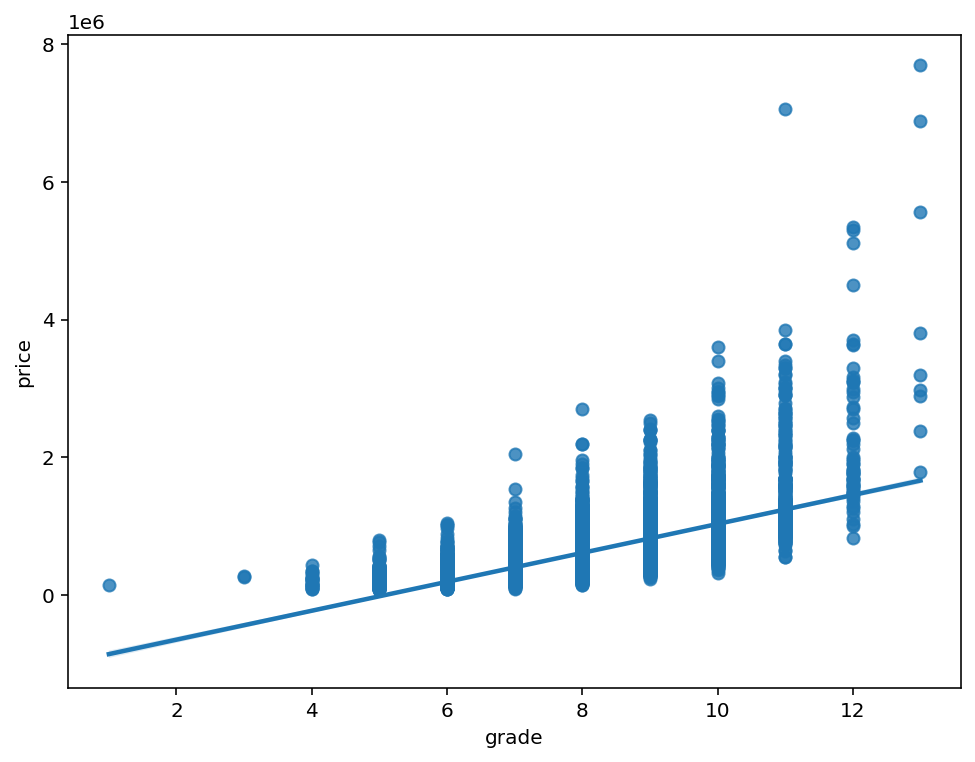

In [296]:
# 시각화해봅시다.
# 편의상 영향력이 큰 변수 TOP 10만 살펴봅니다.
# grade(0.66), sqft_living(0.65), sqft_living15(0.57), sqft_above(0.55), bathrooms(0.5)
# 

# grade의 경우
data = pd.concat([train4['price'], train4['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='grade', y='price', data=data)

▶︎ grade가 집의 등급이니 등급이 높아지면 집값이 높아지는 건 자연스럽죠.

하지만 grade 11 부근에서 이상치가 있는 것 같네요.

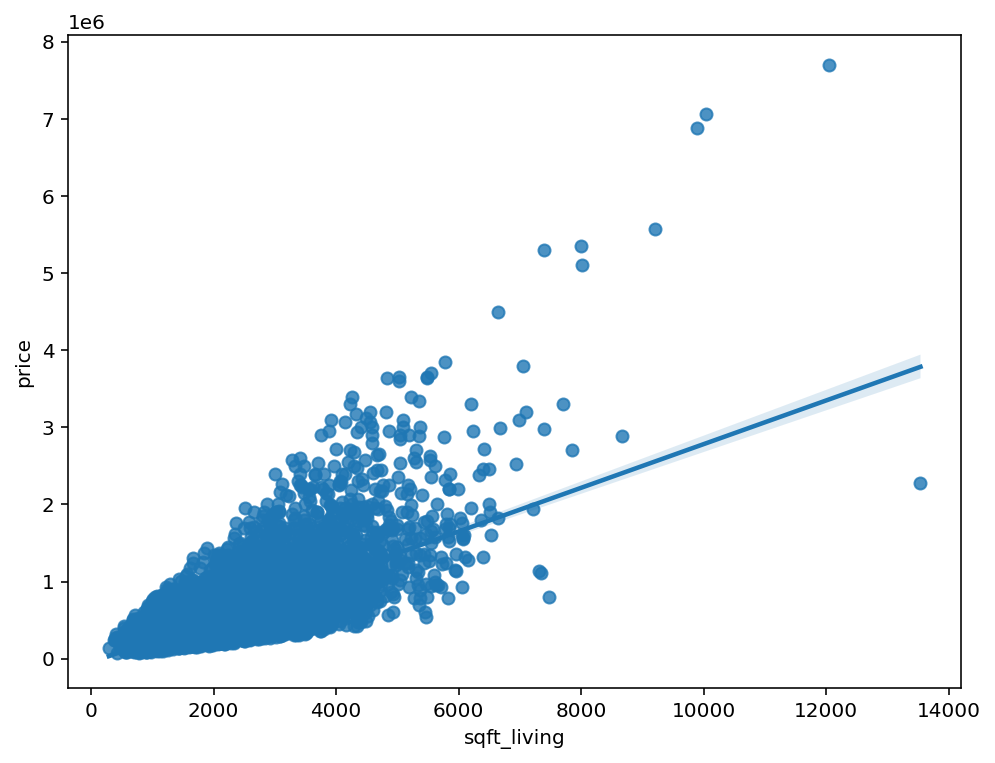

In [297]:
# sqft_living
data = pd.concat([train4['price'], train4['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

▶︎ 흠, 14000 부근에 이상치가 있는 것 같습니다.

일단 다른 데이터들부터 살펴보겠습니다.

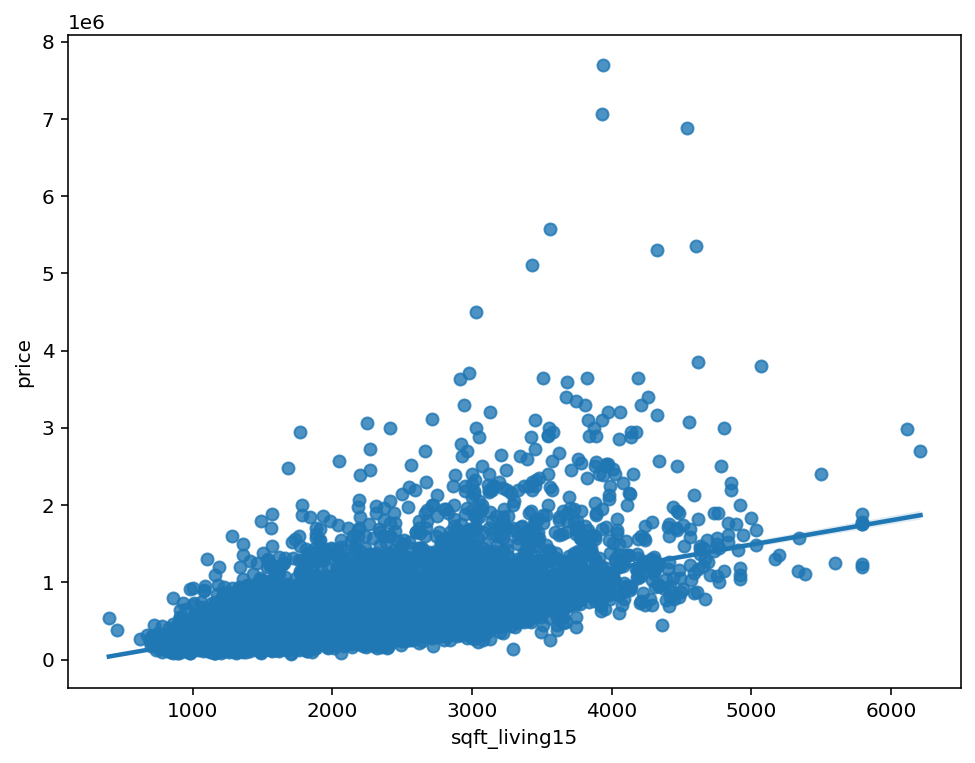

In [298]:
# sqft_living15
data = pd.concat([train4['price'], train4['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

▶︎ 따로 이상치를 구분하기는 어려울 것 같습니다.

sqft_living에 비해 분산이 크네요. 일단 넘어가겠습니다.

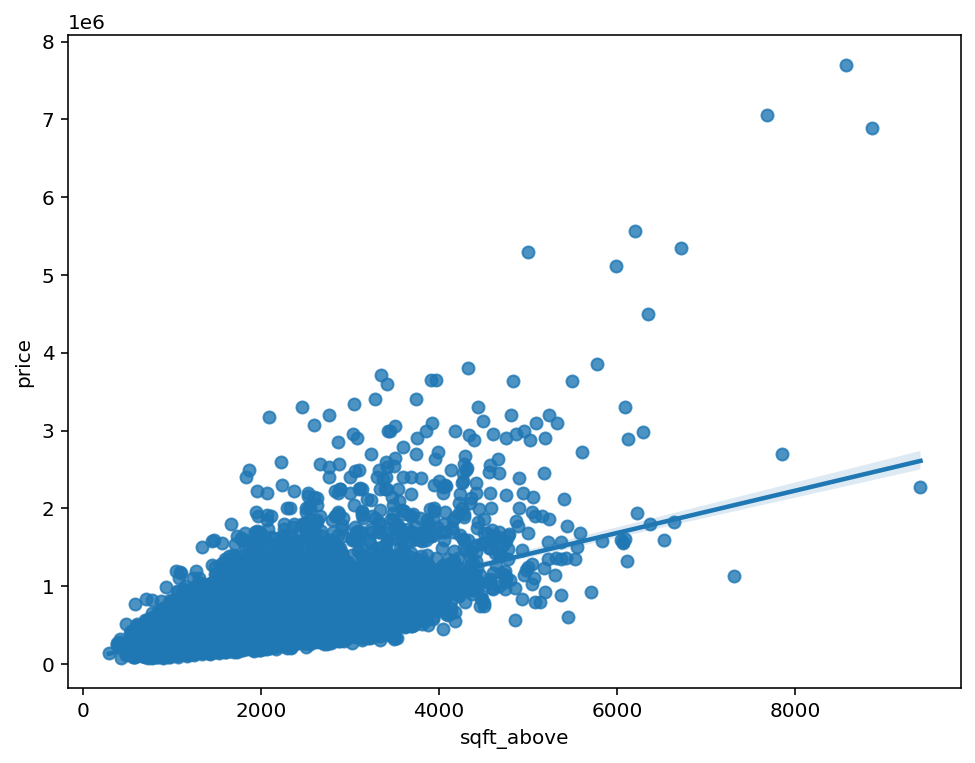

In [299]:
# sqft_above
data = pd.concat([train4['price'], train4['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

▶︎ 이상치는 따로 없는 것 같습니다.

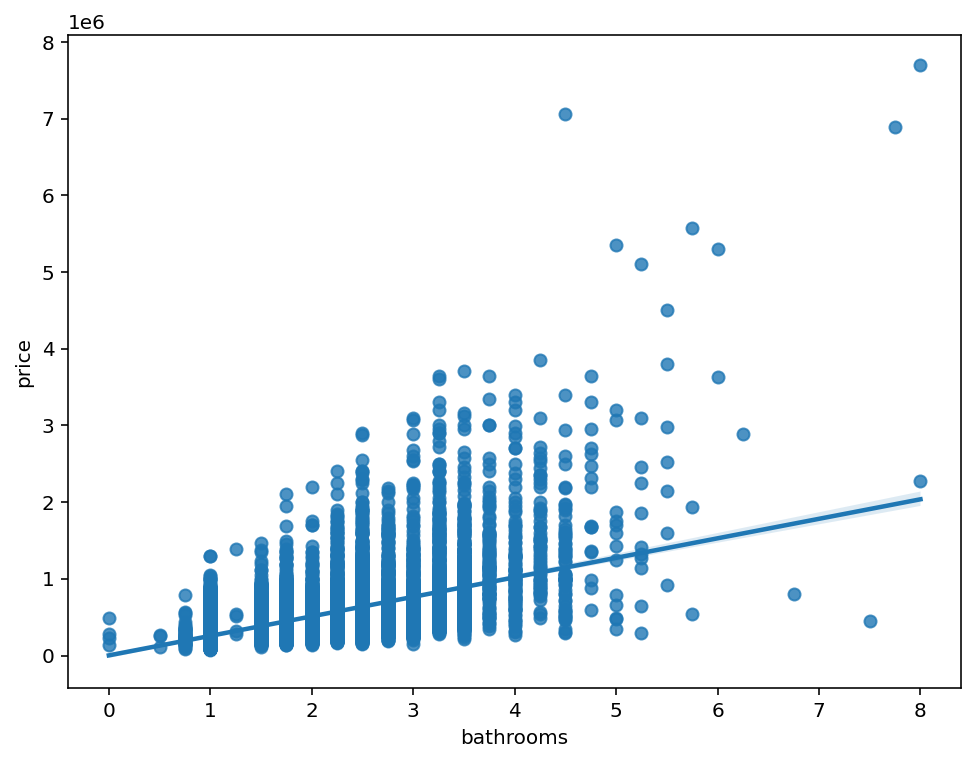

In [300]:
# bathrooms
data = pd.concat([train4['price'], train4['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='bathrooms', y='price', data=data)

▶︎ 흠, 소숫점이 있는 걸로 봐선 순위형 데이터인데 이러면 이상치를 구분할 수 없습니다.

---

### **이상치 제거**

grade, sqft_living 변수들의 이상치를 제거해줍니다.

In [301]:
# grade
train4.loc[(train4['grade'] >= 11) & (train4['price'] > 6000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,5108,20141013,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,20140919,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


▶︎ 특출나게 비싼 집들이란 것 말고는 특이점이 없습니다. 제거해 줍니다.

In [302]:
train4 = train4.loc[train4['id'] != 2775 ]
train4 = train4.loc[train4['id'] != 5108 ]
train4 = train4.loc[train4['id'] != 6469 ]

print('Done!')

Done!


In [303]:
# sqft_living
train4.loc[train4['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


▶︎ 마찬가지로 별다른 특이점이 없습니다. 제거합니다.

In [304]:
train4 = train4.loc[train4['id'] != 8912 ]

print('Done!')

Done!


▶︎ 이상치 처리가 끝났습니다. 다시 모델링을 진행해봅시다.

In [305]:
y4 = np.log1p(train4['price'])

# 불필요한 컬럼 제거
del train4['id']
del train4['price']
del test4['id']


# 하이퍼 파라미터 변경
# xgboost
param_grid = {
    'n_estimators': [50, 100],           # tree 개수 (weak learner) | 디폴트 100
    'max_depth': [1, 10, 20],                 # 트리 깊이 | 디폴트 6
    'eta': [0.05, 0.1]                       # learning rate
}

# model
model_4 = LGBMRegressor(random_state=random_state)


# 그리드 서치 실행
my_GridSearch(model_4, train4, y4, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,eta,max_depth,n_estimators,score,RMSLE
5,0.05,20,100,-0.026799,0.163704
11,0.10,20,100,-0.026799,0.163704
3,0.05,10,100,-0.026828,0.163793
9,0.10,10,100,-0.026828,0.163793
4,0.05,20,50,-0.028926,0.170076
10,0.10,20,50,-0.028926,0.170076
2,0.05,10,50,-0.029027,0.170373
8,0.10,10,50,-0.029027,0.170373
1,0.05,1,100,-0.054876,0.234257
7,0.10,1,100,-0.054876,0.234257


In [306]:
# 모델 생성 및 학습
model_4 = LGBMRegressor(n_iterations=1000, learning_rate=0.05, max_depth=10, n_estimators=100, random_state=random_state)
model_4.fit(train4, y4)


# 예측값 생성
prediction4 = np.expm1(model_4.predict(test4))

prediction4

array([ 500159.24192738,  443668.08283536, 1325992.19812914, ...,
        452244.87551706,  329269.12200117,  428382.62650275])

In [307]:
# 제출용 파일 생성
submission = pd.read_csv('/content/sample_submission.csv')
submission['price'] = prediction4

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', 'final_please')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


/content/submission_lgbm_RMSLE_final_please.csv


## **Result...**